<a href="https://colab.research.google.com/github/fmoghani/zerynth/blob/main/Second_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
df_original = pd.read_csv('/content/out14.csv')

In [6]:
df_original.head(5)
series=df_original['p_avg'].values

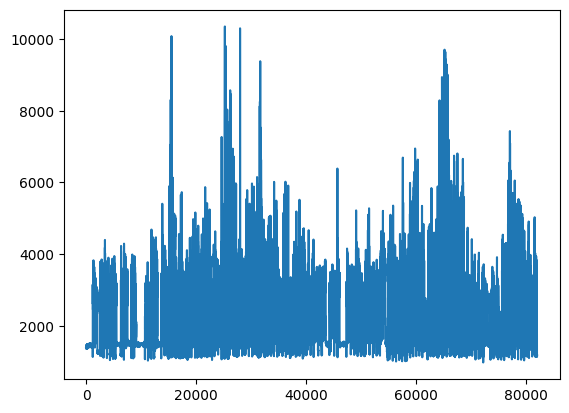

In [7]:
plt.plot(np.arange(len(series)),series)
plt.show()

In [8]:
def show_sample(ds):
  samples=ds.take(1)
  for item in samples:
    print(item)

In [9]:
windows_size=15
ds=tf.data.Dataset.from_tensor_slices(series)
ds=ds.window(windows_size,1,drop_remainder=True)
ds=ds.flat_map(lambda window: window.batch(windows_size))# change the type of samples in data set
ds=ds.map(lambda window:([window],[window])).batch(256)# build the feature and the lable dataset


In [10]:
show_sample(ds)


(<tf.Tensor: shape=(256, 1, 15), dtype=float64, numpy=
array([[[1407.97752   , 1408.9851375 , 1403.94705   , ...,
         1396.557855  , 1390.1762775 , 1390.8480225 ]],

       [[1408.9851375 , 1403.94705   , 1406.9072822 , ...,
         1390.1762775 , 1390.8480225 , 1391.19528051]],

       [[1403.94705   , 1406.9072822 , 1409.32101   , ...,
         1390.8480225 , 1391.19528051, 1383.7947    ]],

       ...,

       [[1454.99967   , 1446.6028575 , 1456.6790325 , ...,
         1441.9006425 , 1452.984435  , 1452.984435  ]],

       [[1446.6028575 , 1456.6790325 , 1451.31076525, ...,
         1452.984435  , 1452.984435  , 1451.65233051]],

       [[1456.6790325 , 1451.31076525, 1458.358395  , ...,
         1452.984435  , 1451.65233051, 1453.3203075 ]]])>, <tf.Tensor: shape=(256, 1, 15), dtype=float64, numpy=
array([[[1407.97752   , 1408.9851375 , 1403.94705   , ...,
         1396.557855  , 1390.1762775 , 1390.8480225 ]],

       [[1408.9851375 , 1403.94705   , 1406.9072822 , ...,
     

In [8]:
samples=ds.take(1)
for a in samples:
    item=a
    break


In [9]:
def add_gaussian_noise(x, stddev=0.1):
    return x + tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype)

In [10]:
windows_size=15
model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1,windows_size]),
    tf.keras.layers.Lambda(lambda x: add_gaussian_noise(x, stddev=0.2),name='noise_layer'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', padding='same', name='conv1d_1'),
    tf.keras.layers.Dropout(0.1, name='dropout_1'),
    tf.keras.layers.LSTM(50, return_sequences=True, name='lstm_1'),  # Return sequences for further LSTM processing
    tf.keras.layers.LSTM(7, return_sequences=True, name='latent'),  # Changed to return sequences to ensure consistent shape
    tf.keras.layers.LSTM(50, return_sequences=True, name='lstm_2'),  # Return sequences to keep the shape consistent
    tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', padding='same', name='conv1d_2'),
    tf.keras.layers.Dropout(0.1, name='dropout_2'),
    tf.keras.layers.Dense(2*windows_size,activation='sigmoid'),
    tf.keras.layers.Dense(windows_size)
])
model.summary()
model.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise_layer (Lambda)        (None, 1, 15)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             3904      
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             23000     
                                                                 
 latent (LSTM)               (None, 1, 7)              1624      
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             11600     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             1

In [11]:
model.fit(ds,epochs=500)

Epoch 1/500
321/321 [==============================] - 20s 38ms/step - loss: 6504925.5000 - mae: 2311.5486
Epoch 2/500
321/321 [==============================] - 13s 41ms/step - loss: 6463866.0000 - mae: 2302.6375
Epoch 3/500
321/321 [==============================] - 11s 35ms/step - loss: 6425829.5000 - mae: 2294.3618
Epoch 4/500
321/321 [==============================] - 12s 36ms/step - loss: 6388488.0000 - mae: 2286.2097
Epoch 5/500
321/321 [==============================] - 13s 39ms/step - loss: 6351547.5000 - mae: 2278.1157
Epoch 6/500
321/321 [==============================] - 15s 46ms/step - loss: 6314900.5000 - mae: 2270.0579
Epoch 7/500
321/321 [==============================] - 13s 39ms/step - loss: 6278488.5000 - mae: 2262.0249
Epoch 8/500
321/321 [==============================] - 13s 39ms/step - loss: 6242285.5000 - mae: 2254.0076
Epoch 9/500
321/321 [==============================] - 11s 35ms/step - loss: 6206271.5000 - mae: 2246.0042
Epoch 10/500
321/321 [===============

In [12]:
intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('latent').output)
j=0
latent=[]
for batch in ds:
        inputs, labels = batch
        if j==0:
          intermediate_output = intermediate_model.predict(inputs)
          latent=intermediate_output
          j+=1
        else:
          intermediate_output = intermediate_model.predict(inputs)
          latent = tf.concat([latent, intermediate_output], axis=0)


5/5 [==============================] - 1s 4ms/step


In [13]:
print(inputs.shape)
print(labels.shape)
print(latent.shape)


(155, 1, 15)
(155, 1, 15)
(82075, 1, 7)


In [14]:
numpy_array = tf.squeeze(latent).numpy()

# Convert numpy array to pandas DataFrame
df = pd.DataFrame(numpy_array)

# Save DataFrame to CSV file using pandas
df.to_csv('latent.csv', index=False, header=False)

In [15]:
df.head()

,0,1,2,3,4,5,6
0,-0.213526,-0.001055,-0.001191,-0.006449,-0.007537,-0.005555,-0.006882
1,-0.213526,-0.001055,-0.001191,-0.006449,-0.007537,-0.005555,-0.006882
2,-0.213526,-0.001055,-0.001191,-0.006449,-0.007537,-0.005555,-0.006882
3,-0.213526,-0.001055,-0.001191,-0.006449,-0.007537,-0.005555,-0.006882
4,-0.213526,-0.001055,-0.001191,-0.006449,-0.007537,-0.005555,-0.006882


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series[0]
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 0}, axis=1)
              .sort_values(0, ascending=True))
  xs = counted[0]
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values(0, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(0)
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series[1]
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 1}, axis=1)
              .sort_values(1, ascending=True))
  xs = counted[1]
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values(1, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(1)
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series[2]
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 2}, axis=1)
              .sort_values(2, ascending=True))
  xs = counted[2]
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values(2, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(2)
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series[3]
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 3}, axis=1)
              .sort_values(3, ascending=True))
  xs = counted[3]
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values(3, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(3)
_ = plt.ylabel('count()')

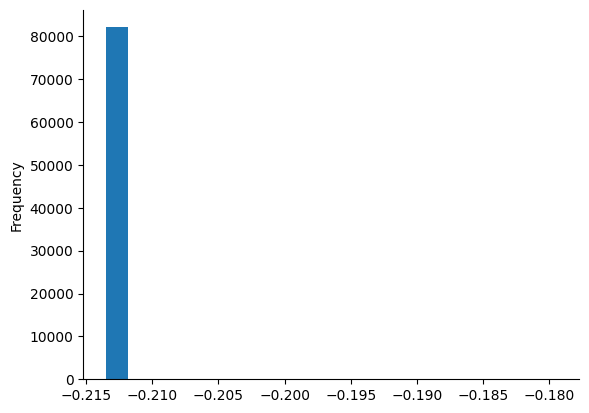

In [16]:
# @title 0

from matplotlib import pyplot as plt
df[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
latent_df = pd.reaad_csv('/content/latent.csv', header=None)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
latent_scaled = scaler.fit_transform(latent_df)

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You might need to adjust these parameters
clusters = dbscan.fit_predict(latent_scaled)

# Add the cluster labels to the dataframe
latent_df['cluster'] = clusters

In [ ]:
df_original['cluster'] = clusters